<a href="https://colab.research.google.com/github/Ashur5457/Semiconductor_Wafer_Defect_Detection/blob/main/%20Data%20augmentation%20%2B%20ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/code/ashishpatel26/wm-811k-wafermap/notebook

原始資料集來自台灣大學的多媒體實驗室：
http://mirlab.org/dataSet/public/


資料集是由臺大實驗室跟台積電合作推出的論文：
Wafer Map Failure Pattern Recognition and Similarity
Ranking for Large-Scale Data Sets

In [ ]:
#載入所需的函數以及套件
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import shuffle
from google.colab.patches import cv2_imshow
from tensorflow.keras.regularizers import l2  # Import l2 regularizer
import tensorflow as tf
from tensorflow.keras import layers, models  #使用 models 取特徵模型
from sklearn.ensemble import RandomForestClassifier  #使用 RF 分類器
from sklearn.metrics import accuracy_score  #使用 RF 精確度計算

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content
!ln -s "/content/drive/MyDrive/Colab Notebooks/" /googledrive
!cp /googledrive/LSWMD.pkl /content

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
ln: failed to create symbolic link '/googledrive/Colab Notebooks': File exists


In [ ]:
# 讀取資料
# pkl是Python裡面的Pickle模組產生的資料封裝檔案，這個檔案只有在Python裡面搭配Pickle模組能用
# Pandas可以利用read_pickle直接把壓縮過的pkl檔案處理成data frame
data = pd.read_pickle('LSWMD.pkl')

In [ ]:
data
# waferMap晶圓表面處理過的外觀圖，dieSize有多少的壞掉的區域的數量，lotName第幾批次，waferIndex晶圓編號
# trianTestLabel原始規畫出來的訓練資料與測試資料，failureType這片晶圓是哪種錯誤型態

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]


In [ ]:
data.shape

(811457, 6)

In [ ]:
data[0:1]

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]


In [ ]:
data['waferMap'][0:1].values

array([array([[0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              ...,
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)], dtype=object)

In [ ]:
# 因為套件改版，改版後的套件變得可以直接比空值，所以只需要做一次即可
# 進行第二次過濾
# 把test以外的過濾掉 -> 剩下"其他"
filter3 = data["trianTestLabel"] != ""
data2 = data[filter3]
data2

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
811450,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2,...",600.0,lot47542,21.0,[[Test]],[[Edge-Loc]]
811451,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47542,22.0,[[Test]],[[Edge-Loc]]
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]


In [ ]:
# 計算每個dieSize的數量
dieSize_counts = data2['dieSize'].value_counts()
dieSize_counts.head(25)


,count
dieSize,
516.0,16437
533.0,14350
776.0,12400
562.0,11252
518.0,9400
741.0,8222
1109.0,7186
1414.0,6723
1376.0,6180


In [ ]:
# 利用DataFrame的過濾器功能進行處理需要的diesize
filter3 = data2["dieSize"] == 533
data3 = data2[filter3]
data3

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
150,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,1.0,[[Training]],[[none]]
151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,2.0,[[Training]],[[none]]
152,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,3.0,[[Training]],[[none]]
153,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,4.0,[[Training]],[[none]]
154,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
679251,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot42179,21.0,[[Test]],[[none]]
679252,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,...",533.0,lot42179,22.0,[[Test]],[[none]]
679253,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",533.0,lot42179,23.0,[[Test]],[[none]]
679254,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",533.0,lot42179,24.0,[[Test]],[[none]]


failureType
[[none]]         13489
[[Loc]]            297
[[Edge-Loc]]       289
[[Center]]          90
[[Random]]          74
[[Scratch]]         71
[[Edge-Ring]]       23
[[Near-full]]       16
[[Donut]]            1
Name: count, dtype: int64


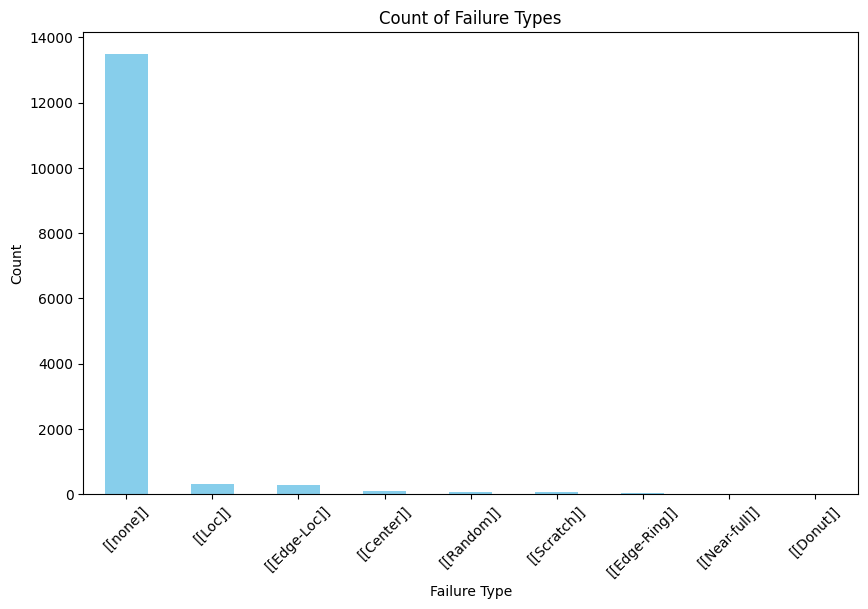

In [ ]:
#確認資料內每個failre type 的資料分布

# 計算每個failureType的數量
failure_counts = data3['failureType'].value_counts()
print(failure_counts)

# 繪製直方圖
plt.figure(figsize=(10, 6))
failure_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Failure Types')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# 以某一筆資料來當例子，取得尺寸
temp = (data3["waferMap"].values)[0]
temp.shape

(26, 26)

In [ ]:
# waferMap size
DSy = 26
DSx = 26

#===========整理原始影像與標籤===================================================
temp = (data3["waferMap"].values)
images = np.stack(temp).reshape(-1, DSy, DSx, 1)
# 訓練集跟驗證集(Label)是依照原始DataSet裡面的規定
labels = data3['failureType'].values
print(images.shape)
print(labels.shape)

#================數據增強========================================================
# 找出 "none" 類別的索引值
none_index = np.where(labels == 'none')[0]
#print(none_index[0:20])
none_images = images[none_index]            # 根據篩選出的索引取出 "none" 的影像
none_labels = labels[none_index]            # 根據篩選出的索引取出 "none" 的標籤

Edge_Loc_index = np.where(labels == 'Edge-Loc')[0]
#print(Edge_Loc_index[0:20])
Edge_Loc_images = images[Edge_Loc_index]
Edge_Loc_labels = labels[Edge_Loc_index]

Edge_Ring_index = np.where(labels == 'Edge-Ring')[0]
#print(Edge_Ring_index[0:20])
Edge_Ring_images = images[Edge_Ring_index]
Edge_Ring_labels = labels[Edge_Ring_index]

Loc_index = np.where(labels == 'Loc')[0]
#print(Loc_index[0:20])
Loc_images = images[Loc_index]
Loc_labels = labels[Loc_index]

Scratch_index = np.where(labels == 'Scratch')[0]
#print(Scratch_index[0:20])
Scratch_images = images[Scratch_index]
Scratch_labels = labels[Scratch_index]

Center_index = np.where(labels == 'Center')[0]
#Center_index = [109,150,407,701,1498]
print('Center_index:', Center_index)
Center_images = images[Center_index]
Center_labels = labels[Center_index]

Random_index = np.where(labels == 'Random')[0]
#print(Random_index[0:20])
Random_images = images[Random_index]
Random_labels = labels[Random_index]

Near_full_index = np.where(labels == 'Near-full')[0]
#print(Near_full_index[0:20])
Near_full_images = images[Near_full_index]
Near_full_labels = labels[Near_full_index]

Donut_index = np.where(labels == 'Donut')[0]
#print(Donut_index[0:20])
Donut_images = images[Donut_index]
Donut_labels = labels[Donut_index]


# 擴增圖片方式
datagen = ImageDataGenerator(
    rotation_range=20,   # 隨機旋轉影像
    horizontal_flip=True,  # 隨機水平翻轉影像
    vertical_flip=True,  # 隨機垂直翻轉影像
#    shear_range=0.03,   # 隨機剪切範圍
#    zoom_range=0.03,    # 隨機縮放範圍
)

# 影像資料進行增強的存放容器
Edge_Loc_aug_images = []
Edge_Loc_aug_labels = []
Edge_Ring_aug_images = []
Edge_Ring_aug_labels = []
Loc_aug_images = []
Loc_aug_labels = []
Scratch_aug_images = []
Scratch_aug_labels = []
Center_aug_images = []
Center_aug_labels = []
Random_aug_images = []
Random_aug_labels = []
Near_full_aug_images = []
Near_full_aug_labels = []
Donut_aug_images = []
Donut_aug_labels = []

# 擴增各 FailureType 的 image 及對應的 label
for image, label in zip(Edge_Loc_images, Edge_Loc_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Edge_Loc_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Edge_Loc_aug_labels.append(label)
        if len(Edge_Loc_aug_images) >= len(none_images):
          break
for image, label in zip(Edge_Ring_images, Edge_Ring_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Edge_Ring_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Edge_Ring_aug_labels.append(label)
        if len(Edge_Ring_aug_images) >= len(none_images):
          break
for image, label in zip(Loc_images, Loc_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Loc_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Loc_aug_labels.append(label)
        if len(Loc_aug_images) >= len(none_images):
          break
for image, label in zip(Scratch_images, Scratch_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Scratch_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Scratch_aug_labels.append(label)
        if len(Scratch_aug_images) >= len(none_images):
          break
for image, label in zip(Center_images, Center_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Center_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Center_aug_labels.append(label)
        if len(Center_aug_images) >= len(none_images):
          break
for image, label in zip(Random_images, Random_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Random_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Random_aug_labels.append(label)
        if len(Random_aug_images) >= len(none_images):
          break
for image, label in zip(Near_full_images, Near_full_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Near_full_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Near_full_aug_labels.append(label)
        if len(Near_full_aug_images) >= len(none_images):
          break
for image, label in zip(Donut_images, Donut_labels):
    image = np.expand_dims(image, 0)
    for batch in datagen.flow(image, batch_size=1):
        Donut_aug_images.append(batch[0].reshape(DSy, DSx, 1))
        Donut_aug_labels.append(label)
        if len(Donut_aug_images) >= len(none_images):
          break


# 將增強後的標籤容器轉換為一維陣列（如果它不是一維的）
Edge_Loc_aug_labels = np.array(Edge_Loc_aug_labels).flatten()
Edge_Ring_aug_labels = np.array(Edge_Ring_aug_labels).flatten()
Loc_aug_labels = np.array(Loc_aug_labels).flatten()
Scratch_aug_labels = np.array(Scratch_aug_labels).flatten()
Center_aug_labels = np.array(Center_aug_labels).flatten()
Random_aug_labels = np.array(Random_aug_labels).flatten()
Near_full_aug_labels = np.array(Near_full_aug_labels).flatten()
Donut_aug_labels = np.array(Donut_aug_labels).flatten()

# 確保 nono_label 是一維陣列
#Near_full_labels = np.array(Near_full_labels).flatten()
none_labels = np.array(none_labels).flatten()


# 將所有標籤轉換為統一的字符串格式，這樣做是為了確保標籤在後續處理時具有相同的數據類型
#Near_full_labels = [str(label) for label in Near_full_labels]
none_labels = [str(label) for label in none_labels]
Edge_Loc_aug_labels = [str(label) for label in Edge_Loc_aug_labels]
Edge_Ring_aug_labels = [str(label) for label in Edge_Ring_aug_labels]
Loc_aug_labels = [str(label) for label in Loc_aug_labels]
Scratch_aug_labels = [str(label) for label in Scratch_aug_labels]
Center_aug_labels = [str(label) for label in Center_aug_labels]
Random_aug_labels = [str(label) for label in Random_aug_labels]
Near_full_aug_labels = [str(label) for label in Near_full_aug_labels]
Donut_aug_labels = [str(label) for label in Donut_aug_labels]


# 整合增強後的影像數據 + "none" 類別的影像數據
combined_images = np.concatenate((none_images, Edge_Loc_aug_images, Edge_Ring_aug_images, Loc_aug_images, Scratch_aug_images,
                  Center_aug_images, Random_aug_images, Near_full_aug_images, Donut_aug_images))
combined_labels = np.concatenate((none_labels, Edge_Loc_aug_labels, Edge_Ring_aug_labels, Loc_aug_labels, Scratch_aug_labels,
                  Center_aug_labels, Random_aug_labels, Near_full_aug_labels, Donut_aug_labels))

# 隨機打亂資料
combined_images, combined_labels = shuffle(combined_images, combined_labels, random_state=42)


print(f"none 資料數量: {len(none_images)}")
print(f"Edge_Loc 數量: {len(Edge_Loc_aug_images)}")
print(f"Edge_Ring 數量: {len(Edge_Ring_aug_images)}")
print(f"Loc_full 數量: {len(Loc_aug_images)}")
print(f"Scratch 數量: {len(Scratch_aug_images)}")
print(f"Center 數量: {len(Center_aug_images)}")
print(f"Random 數量: {len(Random_aug_images)}")
print(f"Near_full 數量: {len(Near_full_aug_images)}")
print(f"Donut 數量: {len(Donut_aug_images)}")
print(combined_images.shape)
print(combined_labels.shape)
#print(none_labels[0], type(none_labels))
#print(Edge_Loc_labels[0], type(Edge_Loc_labels))

(14350, 26, 26, 1)
(14350,)
Center_index: [  397   499   637  2103  3224  3751  4183  4601  5155  5160  5784  6174
  6268  6269  6296  6297  6324  6325  6326  6327  6330  6331  6332  6333
  6334  6335  6336  6352  6614  6615  6723  7022  7128  7208  7285  7533
  7539  7573  7671  7788  7795  7802  7949  8121  8189  8260  8352  8652
  8786  8835  9108  9213  9611 10043 10162 10861 11012 11153 11353 11421
 11477 11520 11578 11583 11651 11674 12020 12172 12212 12268 12281 12437
 12446 12596 12879 12915 12993 13142 13588 13591 13594 13597 13598 13789
 13808 13888 13980 14043 14220 14259]
none 資料數量: 13489
Edge_Loc 數量: 13777
Edge_Ring 數量: 13511
Loc_full 數量: 13785
Scratch 數量: 13559
Center 數量: 13578
Random 數量: 13562
Near_full 數量: 13504
Donut 數量: 13489
(122254, 26, 26, 1)
(122254,)


In [ ]:
# 將數字標籤轉換為one-hot編碼
label_encoder = LabelEncoder()
combined_labels = label_encoder.fit_transform(combined_labels)
combined_labels = to_categorical(combined_labels)

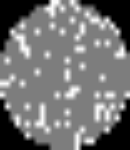

[['none']]


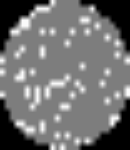

[['none']]


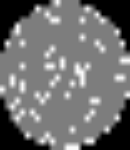

[['none']]


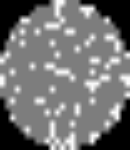

[['none']]


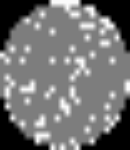

[['none']]


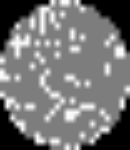

[['none']]


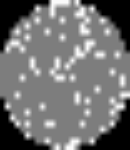

[['none']]


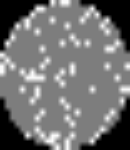

[['none']]


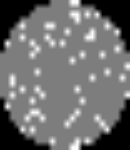

[['none']]


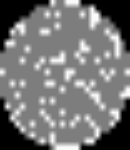

[['none']]
(14350, 26, 26, 1)


In [ ]:
# 展示部分資料
for i in range(10):
  img = images[i] * 125
  img = cv2.resize(img,(130,150))
  cv2_imshow(img)
  print(labels[i])

print(images.shape)

資料集中的可能錯誤樣態列表

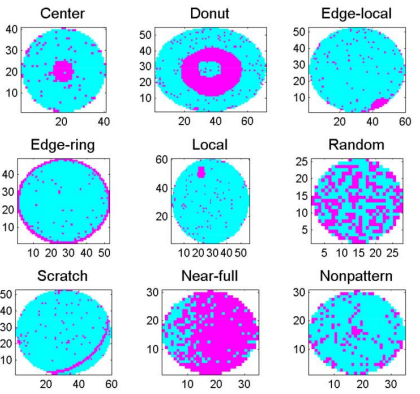

In [ ]:
# 切分訓練與驗證資料集
train_images, val_images, train_labels, val_labels = train_test_split(combined_images, combined_labels, test_size=0.3, random_state=42)
print("訓練資料數量", len(train_images))
print("驗證資料數量", len(val_images))
print("訓練資料標籤數量", len(train_labels))
print("驗證資料標籤數量", len(val_labels))


訓練資料數量 85577
驗證資料數量 36677
訓練資料標籤數量 85577
驗證資料標籤數量 36677


In [ ]:
# 使用ResNet50作為基礎模型
input_shape = (DSy, DSx, 1)
resnet = ResNet50(include_top=False, weights=None, input_tensor=Input(shape=input_shape))

# 添加自定義分類層
x = Flatten()(resnet.output)
x = Dense(128, activation='relu')(x)
output = Dense(len(label_encoder.classes_), activation='softmax')(x)

# 建立模型
model = Model(inputs=resnet.input, outputs=output)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 26, 26, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 32, 32, 1)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 13, 13, 64)     │          3,200 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 13, 13, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 13, 13, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 15, 15, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 7, 7, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 7, 7, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 7, 7, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 7, 7, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 7, 7, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 7, 7, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 7, 7, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 7, 7, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 7, 7, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,844,873 (90.96 MB)

 Trainable params: 23,791,753 (90.76 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# 分類問題，所以loss用categorical_crossentropy，優化器遇事不決用adam
# 編譯模型
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# 設定早期停止，去監測val_loss，連續三輪都無法改善就提前停止，回復最佳權重
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
# 訓練模型
history = model.fit(train_images, train_labels, epochs=30, validation_data=
(val_images, val_labels), callbacks=[early_stopping])

Epoch 1/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 162s 41ms/step - accuracy: 0.9411 - loss: 0.2161 - val_accuracy: 0.9965 - val_loss: 0.0149
Epoch 2/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 88s 33ms/step - accuracy: 0.9921 - loss: 0.0311 - val_accuracy: 0.9966 - val_loss: 0.0150
Epoch 3/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 143s 33ms/step - accuracy: 0.9877 - loss: 0.0537 - val_accuracy: 0.9969 - val_loss: 0.0124
Epoch 4/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 139s 32ms/step - accuracy: 0.9934 - loss: 0.0271 - val_accuracy: 0.9962 - val_loss: 0.0221
Epoch 5/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 141s 32ms/step - accuracy: 0.9939 - loss: 0.0327 - val_accuracy: 0.9936 - val_loss: 0.0291
Epoch 6/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 145s 33ms/step - accuracy: 0.9949 - loss: 0.0206 - val_accuracy: 0.9965 - val_loss: 0.0163
Epoch 7/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 142s 33ms/step - accuracy: 0.9956 - loss: 0.0179 - val_accuracy: 0.9972 - val_loss: 0.0113
Epoch 8/30
2675/2675 ━━━━━━━━━━━━━━━━━━━━ 138s 31ms/step - accuracy: 0

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


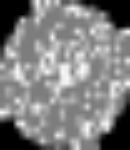

Predicted:  Center
Actual:  Center


In [ ]:
# 預測一筆資料
test_image = val_images[257]
test_label = val_labels[257]
prediction = model.predict(np.expand_dims(test_image, axis=0))

# 顯示要預測的資料原始圖檔
img = test_image * 125
img = cv2.resize(img,(130,150))
cv2_imshow(img)

print('Predicted: ', label_encoder.classes_[np.argmax(prediction)])
print('Actual: ', label_encoder.classes_[np.argmax(test_label)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


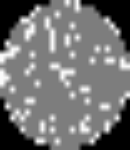

Predicted:  [['none']]
Actual:  [['none']]


In [ ]:
# 預測一筆資料
test_image = val_images[80]
test_label = val_labels[80]
prediction = model.predict(np.expand_dims(test_image, axis=0))

# 顯示要預測的資料原始圖檔
img = test_image * 125
img = cv2.resize(img,(130,150))
cv2_imshow(img)

print('Predicted: ', label_encoder.classes_[np.argmax(prediction)])
print('Actual: ', label_encoder.classes_[np.argmax(test_label)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


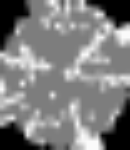

Predicted:  Scratch
Actual:  Scratch


In [ ]:
# 預測一筆資料
test_image = val_images[366]
test_label = val_labels[366]
prediction = model.predict(np.expand_dims(test_image, axis=0))

# 顯示要預測的資料原始圖檔
img = test_image * 125
img = cv2.resize(img,(130,150))
cv2_imshow(img)

print('Predicted: ', label_encoder.classes_[np.argmax(prediction)])
print('Actual: ', label_encoder.classes_[np.argmax(test_label)])

In [ ]:
# 找出val_labels中等於[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]的索引
indices = [i for i, label in enumerate(val_labels) if np.array_equal(label, [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

print(indices)


[]


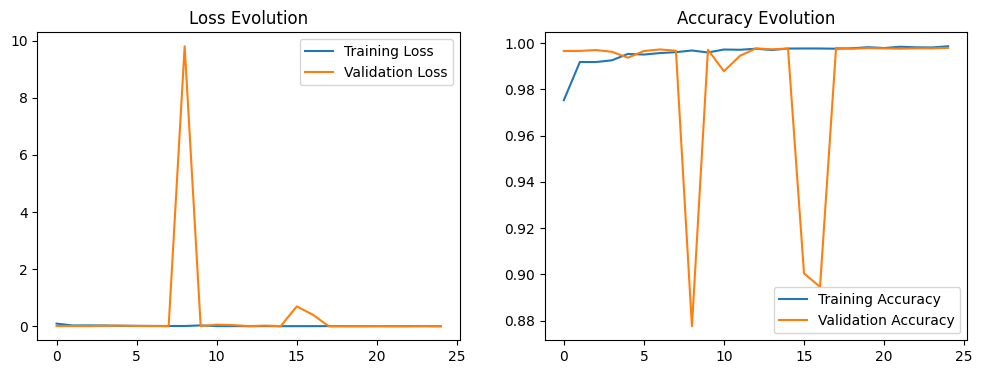

In [ ]:
# 繪製學習曲線
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.show()

1147/1147 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step
Accuracy: 99.79%
              precision    recall  f1-score   support

           0    0.99852   0.99705   0.99779      4072
           1    0.99976   1.00000   0.99988      4094
           2    0.99608   0.99510   0.99559      4084
           3    0.99975   0.99950   0.99962      3999
           4    0.98976   0.99593   0.99283      4174
           5    0.99975   1.00000   0.99988      4036
           6    0.99951   0.99852   0.99901      4062
           7    1.00000   0.99544   0.99772      4169
           8    0.99825   0.99975   0.99900      3987

    accuracy                        0.99790     36677
   macro avg    0.99793   0.99792   0.99792     36677
weighted avg    0.99791   0.99790   0.99790     36677



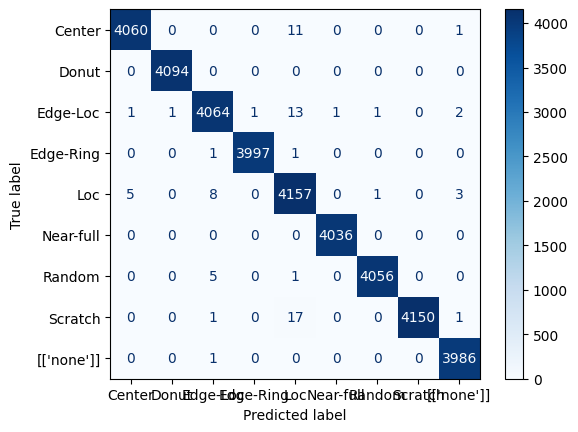

In [ ]:
# 測試集預測結果
val_pred = model.predict(val_images)

# 測試集效能評估 and 混淆矩陣
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
y_true = np.argmax(val_labels, axis=1)
y_pred = np.argmax(val_pred, axis=1)

cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, digits=5)

accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(report)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [ ]:
#print('預測類型', val_pred[0])
#print('實際類型', val_labels[0])
print('測試集 預測shape', val_pred.shape)
print('測試集 實際shape', val_labels.shape)

# 預測結果跟實際結果比對
print('以下為預測錯誤圖片')
for i, VAL_pred in enumerate(val_pred):
#   print(i, label_encoder.classes_[np.argmax(val_pred[i])], label_encoder.classes_[np.argmax(val_labels[i])])
   if (label_encoder.classes_[np.argmax(val_pred[i])] != label_encoder.classes_[np.argmax(val_labels[i])]):
     print(i, label_encoder.classes_[np.argmax(val_pred[i])], label_encoder.classes_[np.argmax(val_labels[i])])

測試集 預測shape (36677, 9)
測試集 實際shape (36677, 9)
以下為預測錯誤圖片
551 Loc Center
1217 Loc Scratch
1390 Loc Edge-Loc
1501 Edge-Loc Random
2016 Loc Edge-Loc
2027 Loc Edge-Loc
3573 Loc Edge-Loc
4132 Loc Scratch
4234 Edge-Loc Loc
4626 Loc Scratch
5036 Loc Center
5231 Donut Edge-Loc
5500 Loc Scratch
6293 Loc Scratch
6596 Edge-Loc Scratch
6934 Loc Edge-Ring
7037 Center Loc
7152 Loc Random
7368 Loc Center
7436 Center Loc
8402 Loc Scratch
8574 Edge-Loc Loc
8711 Loc Scratch
8718 Loc Edge-Loc
8964 Loc Edge-Loc
9025 Center Edge-Loc
9638 Loc Center
9707 Edge-Loc Loc
10033 Loc Scratch
11032 Center Loc
11136 [['none']] Edge-Loc
11260 Loc Center
11802 [['none']] Center
12361 Loc Scratch
12472 Loc Edge-Loc
13155 Loc Scratch
13670 [['none']] Scratch
14641 [['none']] Loc
14660 Loc Scratch
14823 Loc Scratch
16314 Loc Scratch
16680 Random Loc
17145 Loc Edge-Loc
17942 Center Loc
18533 Loc Edge-Loc
18731 Edge-Loc Loc
19408 Edge-Loc [['none']]
19867 [['none']] Loc
20986 Loc Center
21956 Edge-Loc Loc
22481 Loc Center
2